In [ ]:
# Mount google drive
from google.colab import drive
drive.mount('/content/gdrive/')
%cd gdrive/'My Drive'/Internship/Project

Mounted at /content/gdrive/
/content/gdrive/My Drive/Internship/Project


In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import h5py
import os
from sklearn.preprocessing import RobustScaler
from pickle import dump, load
from tqdm.notebook import trange, tqdm
from sklearn.utils import shuffle
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, roc_curve, auc
from pprint import pprint
from sklearn.preprocessing import RobustScaler
from tensorflow.keras.models import Model, model_from_json

In [ ]:
%run Code/Final/DataPreparation.ipynb

In [ ]:
%run Code/Final/Performance_metrics.ipynb

In [ ]:
'''
Class that instantiates the final machine learning pipeline.
signal_scaler: The scaler that scales the original signal (sklearn Scaler object)
autoencoder_time: The autoencoder that reconstructs the signal in the time domain (keras model)
autoencoder_freq: The autoencoder that reconstructs the signal in the frequency domain (keras model)
scaler_time: The scaler that scales the recnstruction errors in the time domain (sklearn Scaler object)
scaler_freq: The scaler that scales the recnstruction errors in the frequency domain (sklearn Scaler object)
final_classifier: The final LSTM classifier (keras model)
lookback: How far in the past we look to classify one sample (int)
'''
class Classifier:
  def __init__(self, signal_scaler, autoencoder_time, autoencoder_freq, 
               scaler_time, scaler_freq, final_classifier, lookback):
    
    self.signal_scaler = signal_scaler
    self.autoencoder_time = autoencoder_time
    self.autoencoder_freq = autoencoder_freq
    self.scaler_time = scaler_time
    self.scaler_freq = scaler_freq
    self.final_classifier = final_classifier
    self.lookback = lookback


  '''
  INPUT
  signal: the signal as given by NEMO with shape (4,-1)
  OUTPUT
  likelihoods: the likelihood that a 125 segment is an anomaly
  '''
  def assess_signal(self, signal):

    signal = remove_inf(signal)

    # signal has shape (4, -1)
    # after scaling it becomes (-1, 4)
    signal = self.signal_scaler.transform(signal.T)

    signal = np.reshape(signal, newshape=(-1, 125, 4)) 

    # scaled fourier transform
    fourier = np.abs(np.fft.fft(signal, axis=1))[:,:signal.shape[1]//2,:] * 1/signal.shape[1]

    # find the errors of time and frequency domain
    error_t = find_errors(signal, self.autoencoder_time)
    error_f = find_errors(fourier, self.autoencoder_freq)

    # scale the errors
    error_t = self.scaler_time.transform(np.expand_dims(error_t, axis=1)).flatten()
    error_f = self.scaler_freq.transform(np.expand_dims(error_f, axis=1)).flatten()

    # creat final 2d error array, shape=(-1, 2)
    errors = np.vstack((error_t, error_f)).T

    # create the errors with the history to feed in the final classifier
    errors_with_lookback = create_lookback_2d(errors, lookback=self.lookback)  

    # predict the likelihood that something is an anomaly
    # 1: anomaly
    # 0: normal
    # 0 < likelihood < 1
    y_likelihoods = self.final_classifier.predict(errors_with_lookback).flatten()

    return y_likelihoods


In [ ]:
# load scalers
scaler_time = load(open('Models/Final/scaler_errors_t.pkl', 'rb'))
scaler_freq = load(open('Models/Final/scaler_errors_f.pkl', 'rb'))
signal_scaler = load(open('Models/Final/signal_scaler.pkl', 'rb'))

In [ ]:
# load models
model_time = load_model('Models/Final/time_autoencoder')
model_freq = load_model('Models/Final/freq_autoencoder')
final_classifier = load_model('Models/Final/lstm_classifier')

Loaded model from disk
Loaded model from disk
Loaded model from disk


In [ ]:
# initialize model
model = Classifier(signal_scaler, model_time, model_freq, scaler_time, scaler_freq, final_classifier, lookback=120)

In [ ]:
# load test set
file_signal = h5py.File('Data/Clean/test_set.h5', 'r')
data_raw = file_signal['data'][()]
bad_quality = file_signal['bad_quality'][()]
recording_endings = file_signal['recording_endings'][()]
file_signal.close()

In [ ]:
# reconstruct the recordings with their labels in a list of numpy arrays
recordings_labels = reconstruct_recordings(data_raw, bad_quality, recording_endings)

In [ ]:
# Calculate the likelihoods of all testing samples to assess the performance of the model
y_true_y_lik = []
y_true = np.zeros(0)
y_lik = np.zeros(0)
for r, l in tqdm(recordings_labels):
  r = np.reshape(r, (-1,4)).T
  y = model.assess_signal(r)
  y_true_y_lik.append((l, y))
  y_true = np.concatenate((y_true, l))
  y_lik = np.concatenate((y_lik, y))

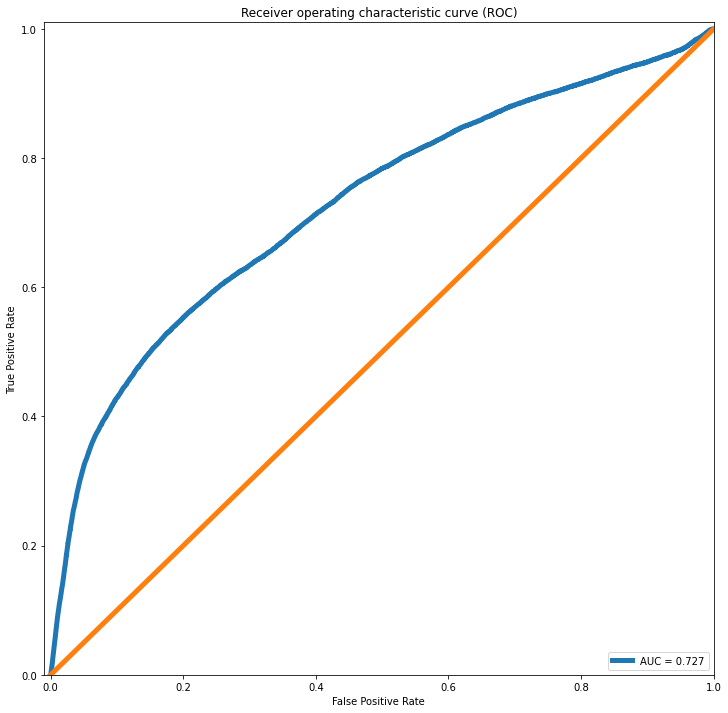

In [ ]:
roc_auc(y_true, y_lik)

(x,y)=(90.32, 0.37)


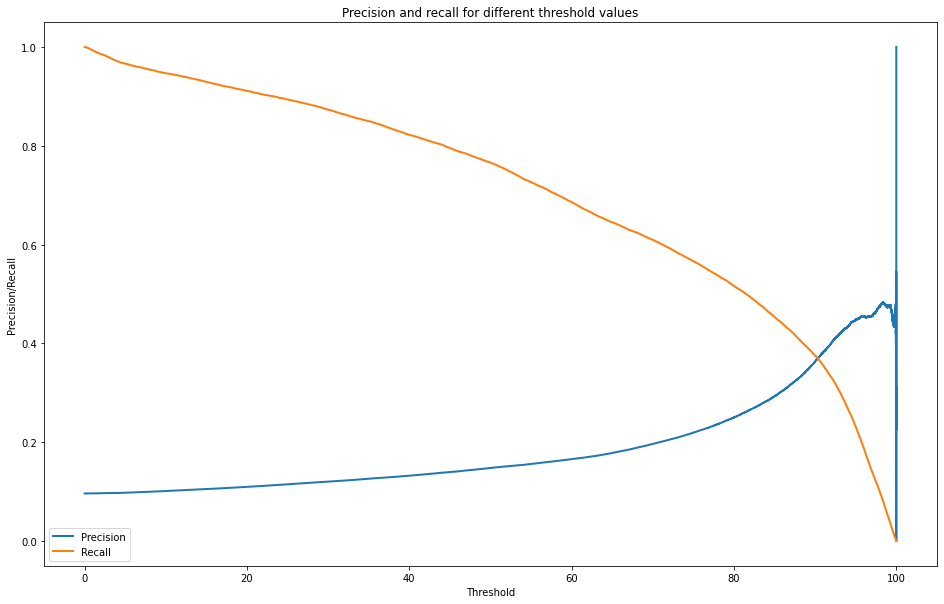

In [ ]:
precision_recall_curv(y_true, y_lik)

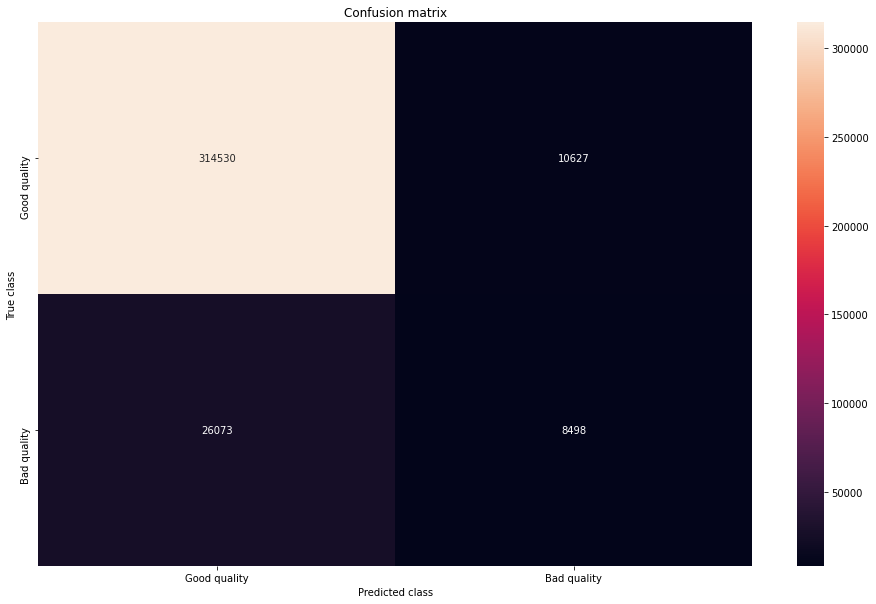

In [ ]:
confusion(y_true, y_lik, thr=0.9)

*Isolate misclassifications*

In [ ]:
'''
Find all the types of (mis-)classifications, TP, TN, FP, FN
signal: the input signal
y_true: the labels
y_like: the likelihoods
threshold: the threshold
'''
def misclassifications(signal, y_true, y_like, thresh=0.5):

  # signal has shape (4, -1)
  # after scaling it becomes (-1, 4)
  signal = np.reshape(signal, newshape=(-1, 125, 4)) 

  # idxs = predicted
  anomaly_idxs = np.where(np.array(y_like) >= thresh)[0]
  normal_idxs = np.where(np.array(y_like) < thresh)[0] 

  # indexes = real
  anomaly_indices = np.where(y_true == 1)[0]
  normal_indices = np.where(y_true == 0)[0]

  # positive = low quality = 1
  # negative = normal quality = 0

  tp_ind = np.intersect1d(anomaly_indices, anomaly_idxs)
  fp_ind = np.intersect1d(normal_indices, anomaly_idxs)
  tn_ind = np.intersect1d(normal_indices, normal_idxs)
  fn_ind = np.intersect1d(anomaly_indices, normal_idxs)

  fp = signal[fp_ind]
  fn = signal[fn_ind]
  tp = signal[tp_ind]
  tn = signal[tn_ind]

  return fp, fn, tp, tn, fp_ind, fn_ind, tp_ind, tn_ind

In [ ]:
fp, fn, tp, tn, fp_ind, fn_ind, tp_ind, tn_ind = misclassifications(signal, signal_scaler, signal_quality, y)

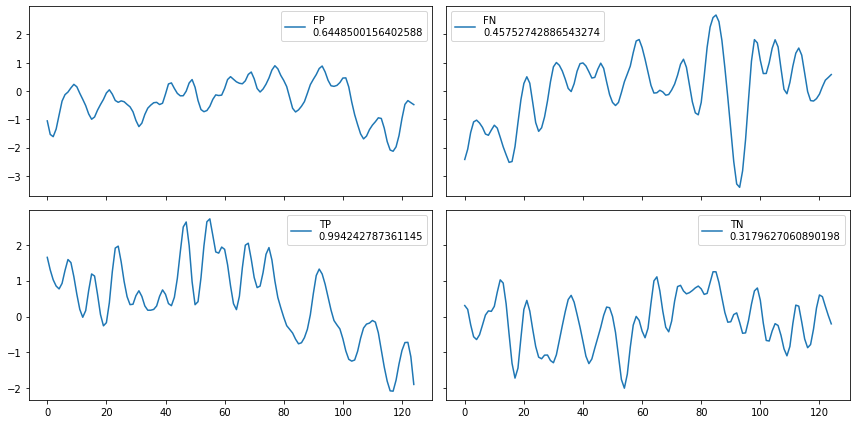

In [ ]:
# FP: true -> normal, classified - > anomaly
# FN: true -> anomaly, classified - > normal

id = 2
channel = 0

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(12,6))
ax1.plot(np.arange(125), fp[fp_ind[id], :, channel],  label='FP\n{}'.format(y[fp_ind[id]])) 
ax1.legend()
ax2.plot(np.arange(125), fn[fn_ind[id], :, channel],  label='FN\n{}'.format(y[fn_ind[id]])) 
ax2.legend()
ax3.plot(np.arange(125), tp[tp_ind[id], :, channel],  label='TP\n{}'.format(y[tp_ind[id]])) 
ax3.legend()
ax4.plot(np.arange(125), tn[tn_ind[id], :, channel],  label='TN\n{}'.format(y[tn_ind[id]])) 
ax4.legend()
plt.tight_layout()
plt.show()

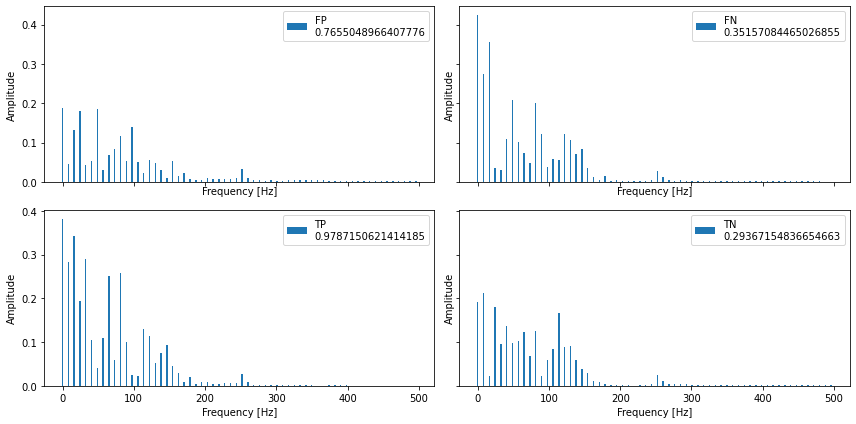

In [ ]:
# FP: true -> normal, classified - > anomaly
# FN: true -> anomaly, classified - > normal

id = 10
channel = 0

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(12,6))
ax1.bar(f, fourier_fp[id,:,channel], width=2, label='FP\n{}'.format(y[fp_ind[id]]))
ax1.legend()
ax1.set_ylabel("Amplitude")
ax1.set_xlabel("Frequency [Hz]")
ax2.bar(f, fourier_fn[id,:,channel], width=2, label='FN\n{}'.format(y[fn_ind[id]]))
ax2.legend()
ax2.set_ylabel("Amplitude")
ax2.set_xlabel("Frequency [Hz]")
ax3.bar(f, fourier_tp[id,:,channel], width=2, label='TP\n{}'.format(y[tp_ind[id]]))
ax3.legend()
ax3.set_ylabel("Amplitude")
ax3.set_xlabel("Frequency [Hz]")
ax4.bar(f, fourier_tn[id,:,channel], width=2, label='TN\n{}'.format(y[tn_ind[id]]))
ax4.legend()
ax4.set_ylabel("Amplitude")
ax4.set_xlabel("Frequency [Hz]")
plt.tight_layout()
plt.show()